# X-Ray measurements
Oftentimes one has X-ray measurements alongside MSI or XRF measurements. In this chapter, we will discuss how to 
* Process the X-ray image by removing the plastic lining at the boundaries
* Get the right depth section from a longer core
* Addition to an MSI measurement will be covered in a later chapter
The `XRay` class is a wrapper around the `ImageSample` class, so some functionality should be familiar. One of the main differences is that the `XRay` class needs a depth span (the depth span covered by the image).

## Initialization
Let's take a look at the example in the 'Data' folder, it covers a depth span from 480 to 510 cm below the seafloor:

In [1]:
from maspim import XRay

%matplotlib inline

path_image_file = r'Data\MD_03_2621_480-510_sliced_1200dpi.tif'

xray = XRay(depth_section=(480, 510), path_image_file=path_image_file)
print(xray)

obj_color: dark
image_file: MD_03_2621_480-510_sliced_1200dpi.tif
_hw: [2423, 14760]
_image: Numpy array of type uint8, with shape (2423, 14760, 3)
path_folder: Data
depth_section: [480, 510]
_bars_removed: False
_use_rotated: True


Pay attention to the `obj_color` attribute, it is determined automatically if not provided and should be *'dark'* in this case.

## Correcting rotation
The first thing we want to address is the rotation. You can provide an angle directly or let it be estimated from the bounding box of the `main_contour`. If you don't set `use_rotated=False` anything that uses the image will evoke the `set_rotation` method, so let's first look at the image before rotation and then after

INFO:maspim.imaging.util.image_helpers:Determining threshold for background intensity with OTSU.
INFO:maspim.imaging.xray.main:found an angle of -0.2 degrees centered at (7470.5810546875, 1189.1253662109375)


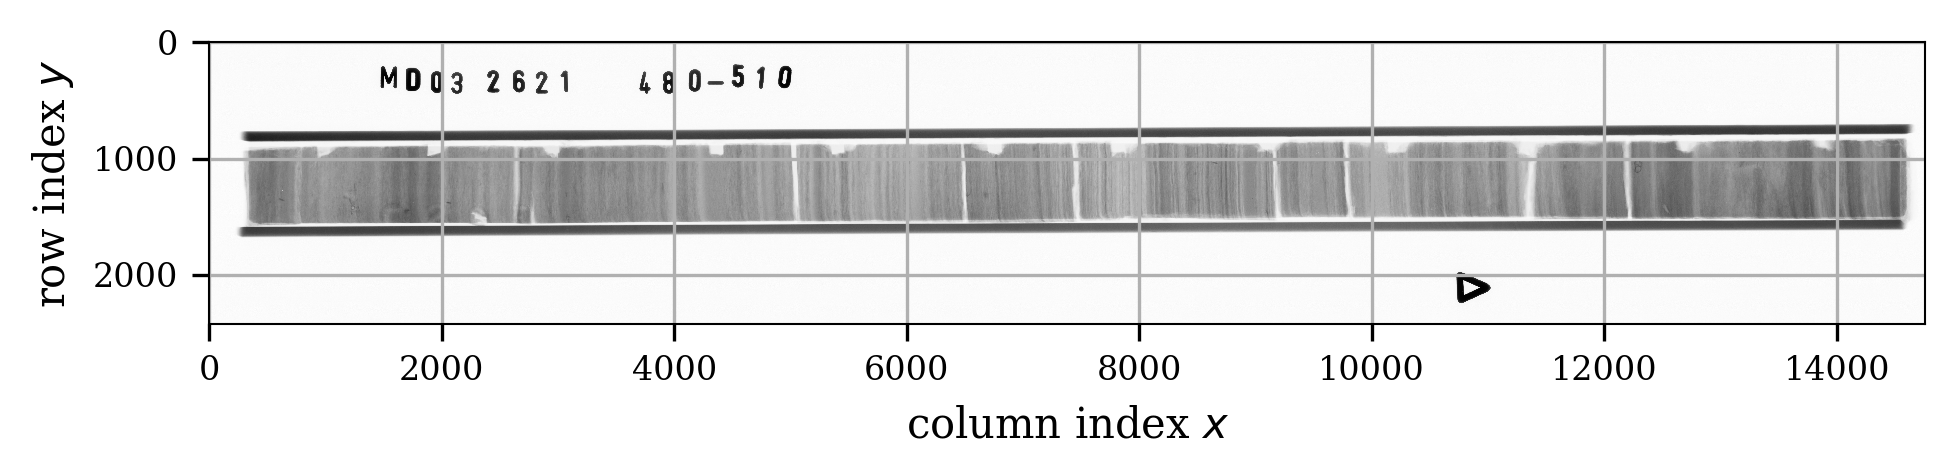

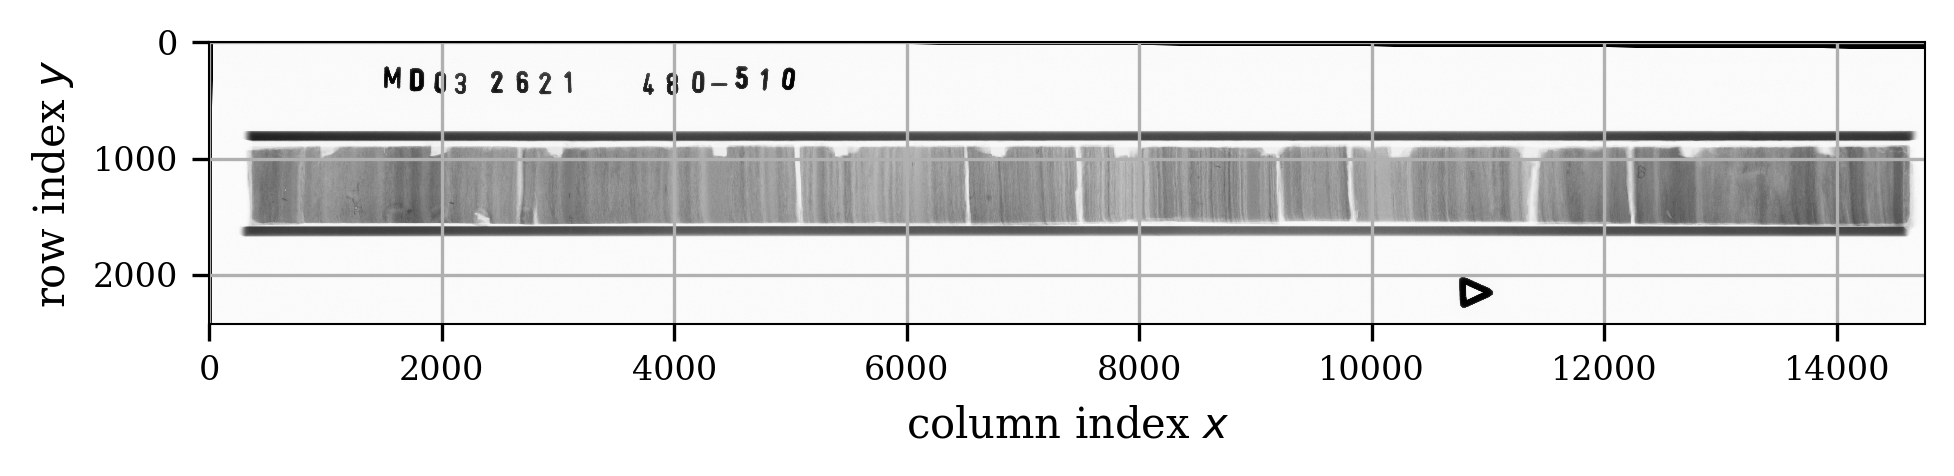

In [2]:
import logging
from maspim import plt_cv2_image

logging.basicConfig(level=logging.INFO)
xray.set_rotation()
logging.basicConfig(level=logging.WARNING)

plt_cv2_image(xray._image, grid=True)
plt_cv2_image(xray.require_image_rotated(), grid=True)


0.2 degrees is not much, but if you look closely, you will notice that the top image is rotated slightly, but the bottom one isn't.

## Sample area
Now we have to find the image region in which the core is located. As for the `ImageSample` we use the optimizer to achieve this:

INFO:maspim.imaging.main:searching optimal parameters for box
INFO:maspim.imaging.main:found box with [9.99741347e-01 3.98999998e-01 3.19649983e+03 4.88500104e+02]
INFO:maspim.imaging.main:solver converged: True


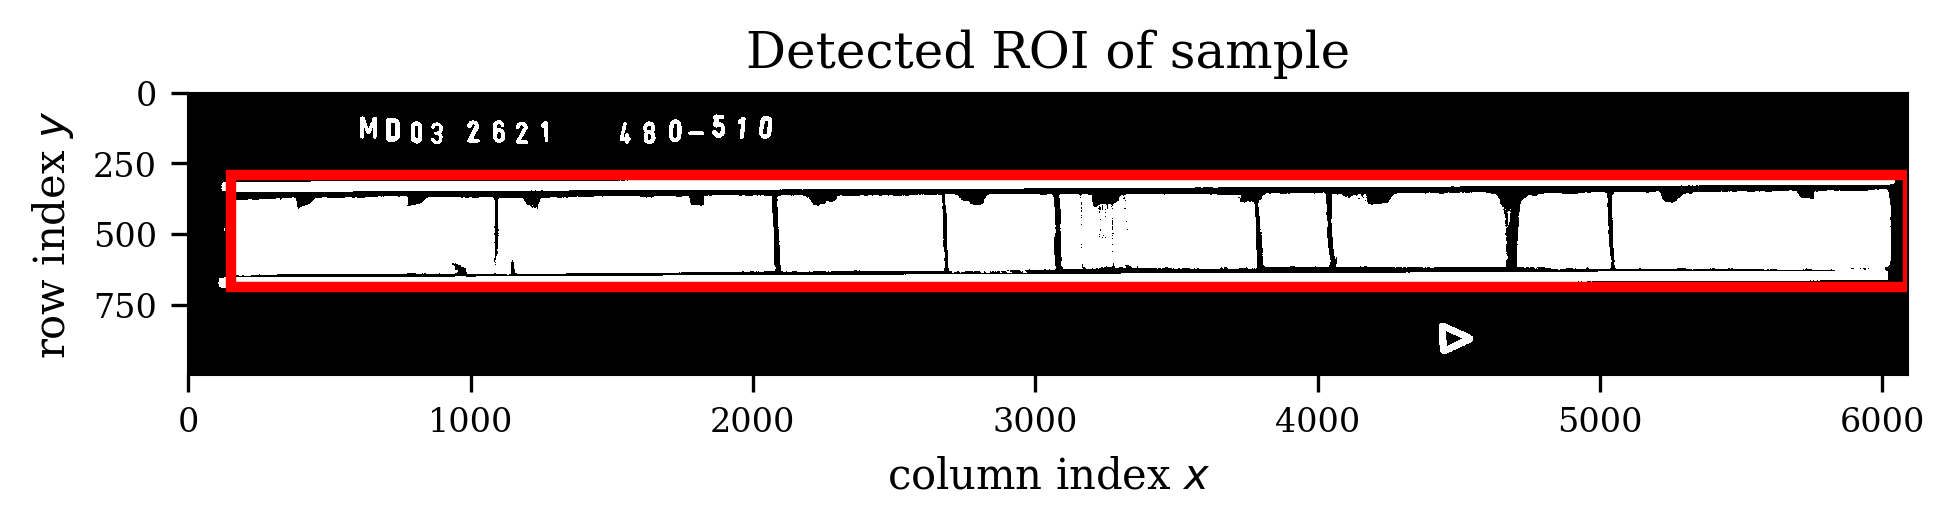

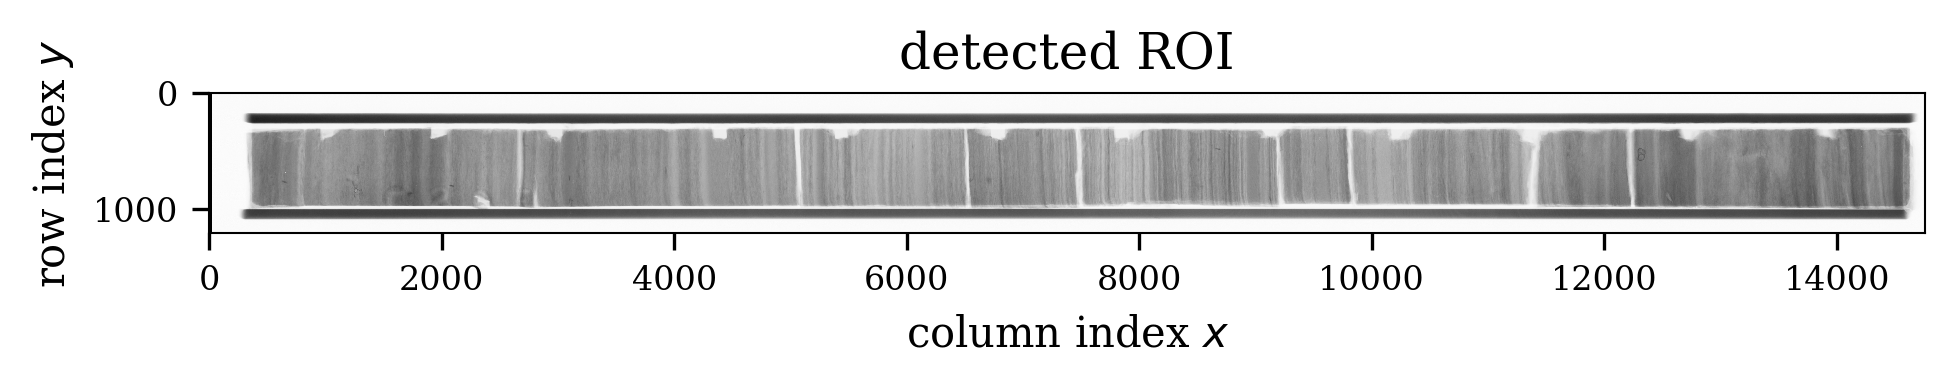

INFO:maspim.imaging.util.image_helpers:Determining threshold for background intensity with OTSU.


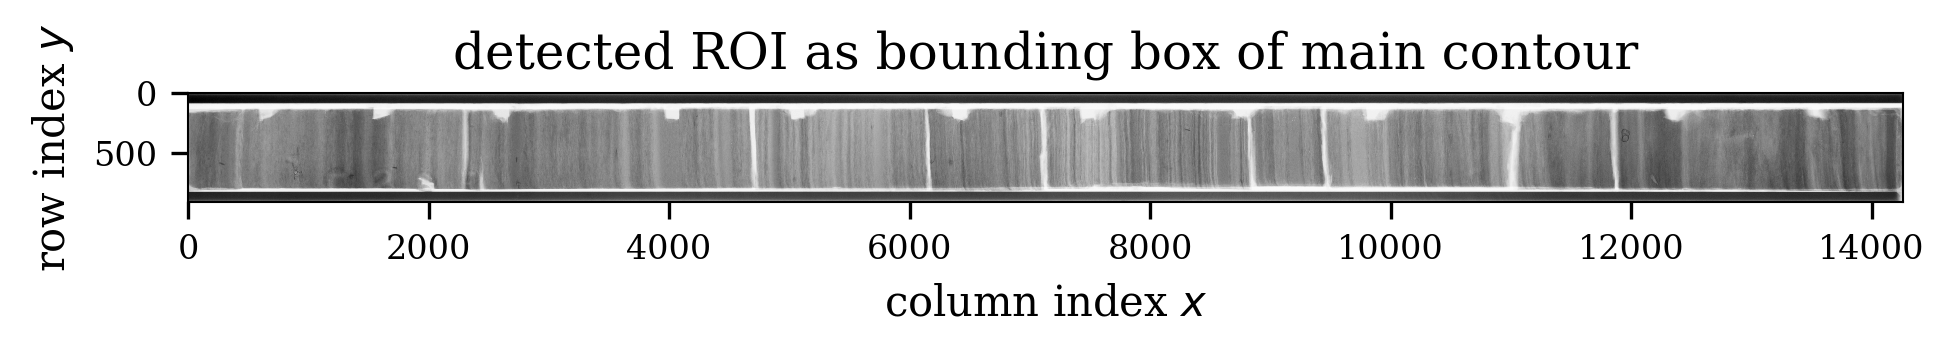

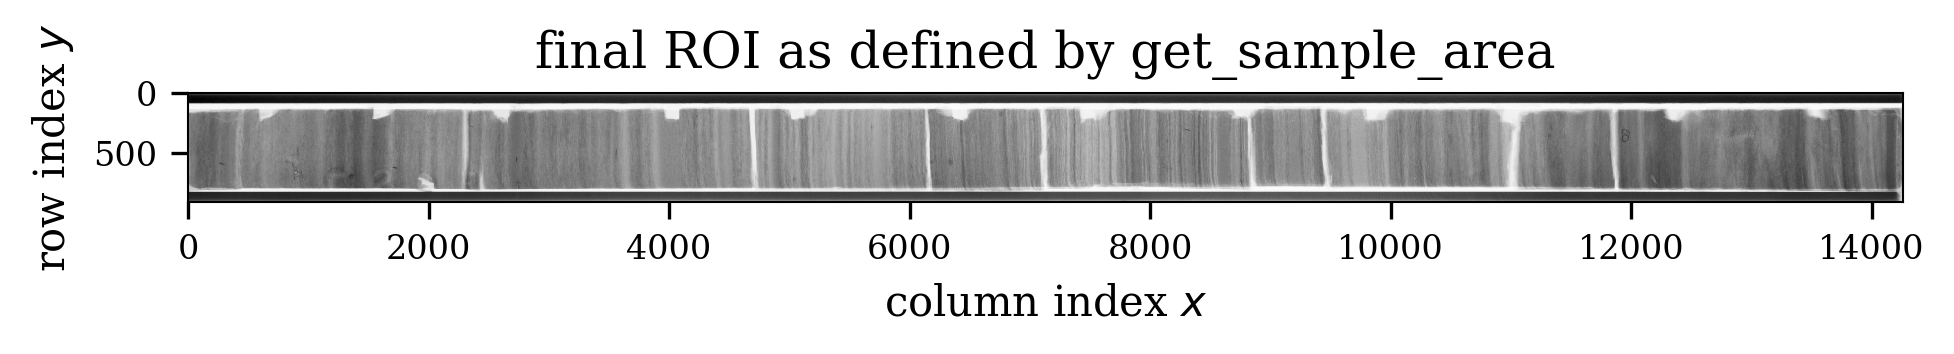

In [3]:
xray.set_sample_area(plts=True)

Alright, that worked out as it should. Remember, if you run into issues you can alyways use `xray.set_sample_area(interactive=True)` to set the area manually. 

## Removing plastic liners
You probably have already noticed the black lines at the top and bottom, which is the plastic liner surrounding the core half. We wish to remove those areas because we need the precise area of the core to combine it with other datasets. For this we can use the `remove_bars` method: 

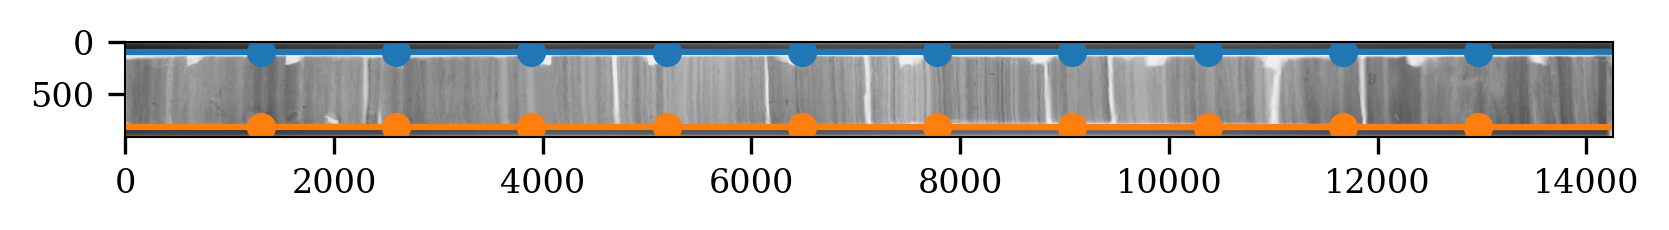

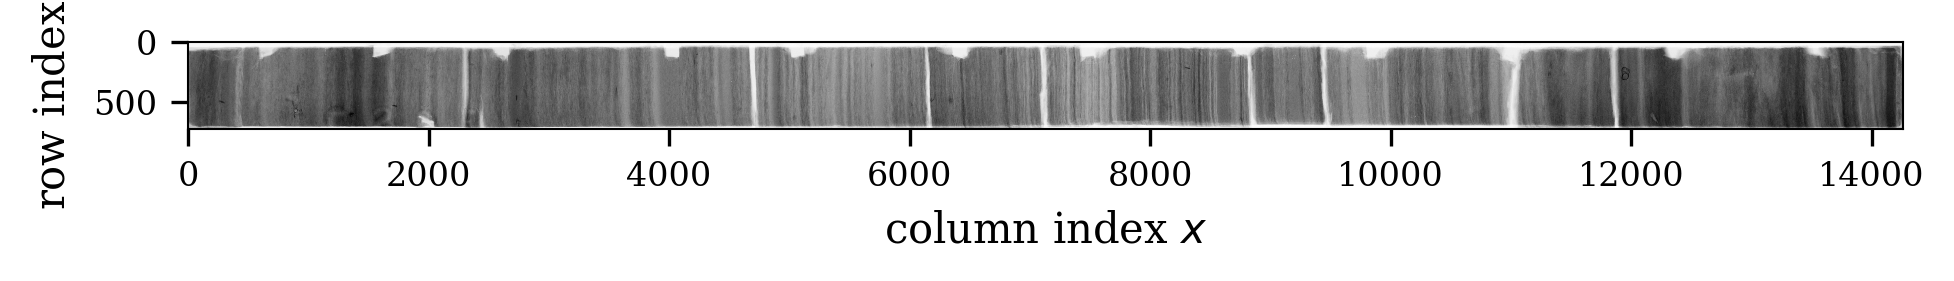

In [4]:
xray.remove_bars(plts=True)

The dots in the first image show at which depths transects were taken. The inwards bounds of the liners are taken as the inflection points. Transects look something like this (or the inverse, depending on whether the colors in the image are inverted):

|_
The x's mark the inflection points. We do this for `n_sections` along the photo and fit a line through the blue and orange points respectively. Everything above the blue and below the orange line will be set to the background color and the sample a will berea cped. ___

## Loading and saving
The object will be saved in the folder from which the image was taken. In this case that is the 'Data' folder

In [5]:
xray.save()

INFO:maspim.util.convenience:saving image object with {'_hw', '_xywh_ROI', 'depth_section', '_angle', '_use_rotated', '_bars_removed', '_center_xy', 'image_file', 'obj_color'} to Data


Let's check that loading works correctly

In [6]:
xray_new = XRay(path_image_file=path_image_file)
xray_new.load()
print(xray_new)

INFO:maspim.imaging.main:obj appears to be dark
INFO:maspim.util.convenience:loaded XRay with keys {'_hw', '_xywh_ROI', 'depth_section', '_angle', '_use_rotated', '_bars_removed', '_center_xy', 'image_file', 'obj_color'}


obj_color: dark
image_file: MD_03_2621_480-510_sliced_1200dpi.tif
_hw: [2423, 14760]
_image: Numpy array of type uint8, with shape (2423, 14760, 3)
path_folder: Data
depth_section: [480, 510]
_bars_removed: True
_use_rotated: True
_xywh_ROI: [368, 855, 14261, 722]
_angle: -0.24854278564453125
_center_xy: [7470.5811, 1189.1254]


## Getting a subregion
We can get a certain section of the longer core using the `get_roi_from_section` method. It will return an `XRayROI` instance which is an alias for `ImageROI` but it will have a different name when saved so we don't run into conflicts with `ImageROI` saves:

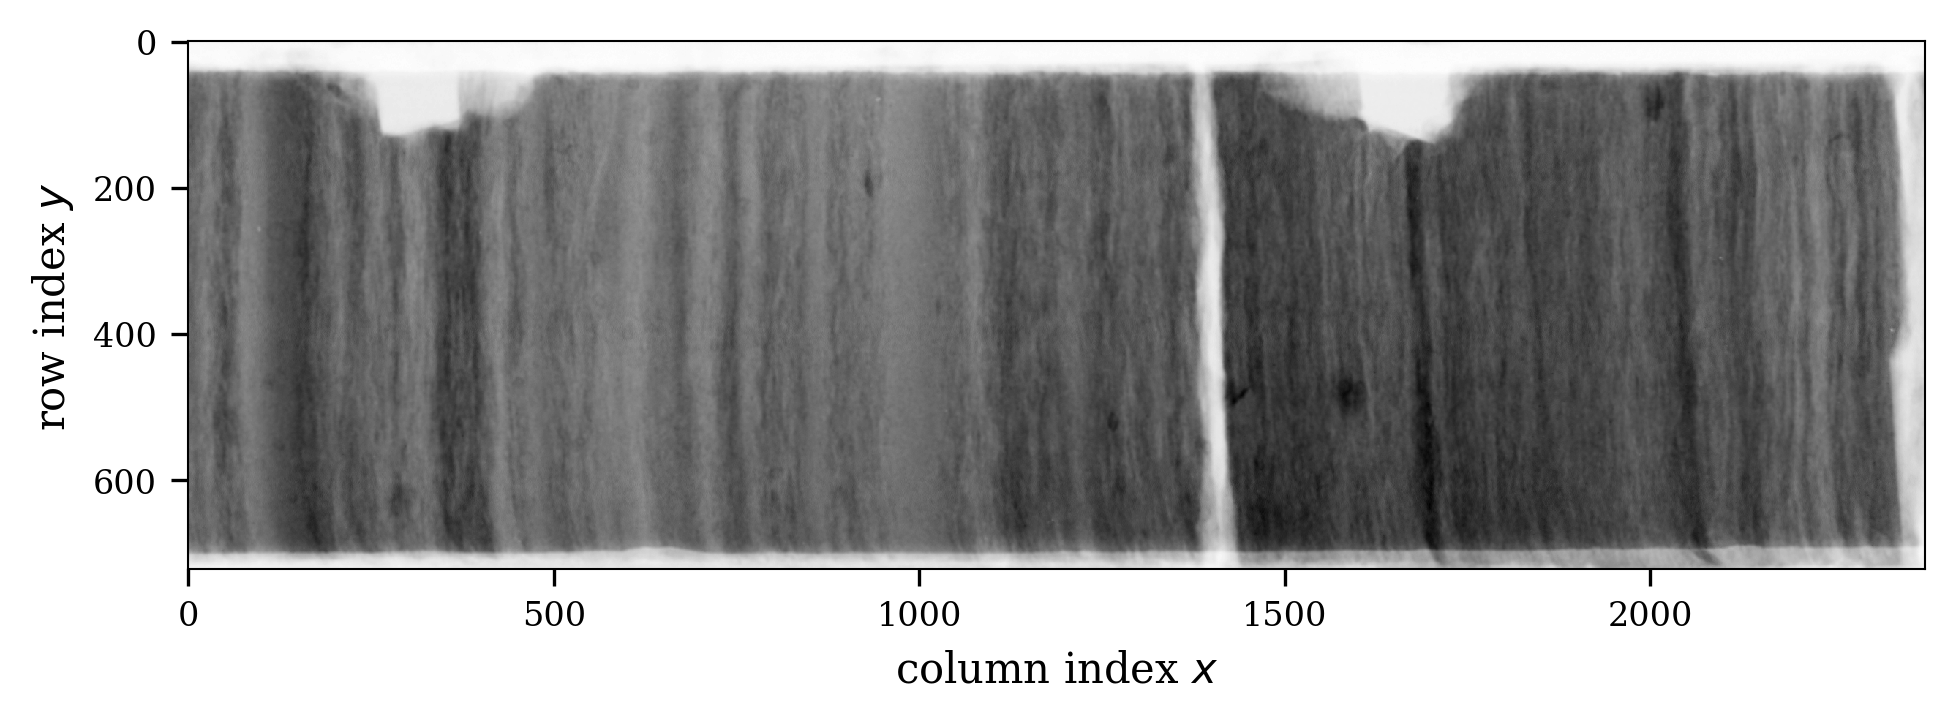

INFO:maspim.util.convenience:saving image object with {'_hw', 'obj_color', 'age_span', '_image'} to Data


In [7]:
roi = xray.get_roi_from_section(490, 495)
roi.plot()

roi.save()

Now you should have an *'ImageROI.pickle'* and *'XRayROI.pickle'* file in your *'Data'* folder